In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config["database.host"] = '134.2.168.16'
dj.config['schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join

import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.from_nnfabrik import DataInfo

In [3]:
import insilico_stimuli
from insilico_stimuli.stimuli import BarsSet, GaborSet, PlaidsGaborSet, DiffOfGaussians, CenterSurround, PlaidsGratingSet
from insilico_stimuli.parameters import *

In [4]:
# nnfabrik main
from nnvision.tables.main import MonkeyExperiment
from nnvision.tables.from_mei import TrainedEnsembleModel, MEIMethod
from featurevis.main import MEITemplate
from nnvision.tables.measures import OracleScore

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

# Load the model

In [ ]:
# loading model
ensemble_hash = 'e7a8d0b961ee37ffda0779bfed95f1cf'

model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model = TrainedModel().load_model(model_key, include_dataloader=False)
model.eval()

In [6]:
# canvas size
h = 41
w = 41
canvas_size = [w, h]

In [7]:
data_key='3631807112901'                   # model specifics for optimization
n_units = model.readout[data_key].outdims  # number of model neurons 
total_trials = 30                          # for optimization
unit_idx = 27                              # arbitrary model neuron

# model readout coordinates from -1, 1 
model.readout[data_key].grid  # needs to be converted to canvas size by min-max-normalization

Parameter containing:
tensor([[[[-0.0482,  0.0579]],

         [[-0.2883,  0.0565]],

         [[-0.2923,  0.1154]],

         [[ 0.0009,  0.0505]],

         [[-0.0600, -0.0448]],

         [[-0.2938,  0.1244]],

         [[-0.2965,  0.3931]],

         [[-0.1132,  0.4247]],

         [[ 0.0509,  0.3379]],

         [[-0.2086,  0.3161]],

         [[-0.3293,  0.0871]],

         [[-0.2918,  0.3593]],

         [[-0.0455,  0.0573]],

         [[-0.2696,  0.3134]],

         [[-0.1766,  0.2250]],

         [[-0.1001,  0.0033]],

         [[-0.0216,  0.0470]],

         [[-0.3051,  0.2617]],

         [[-0.2893,  0.0936]],

         [[-0.1083,  0.3236]],

         [[-0.0547,  0.3937]],

         [[-0.2828,  0.1749]],

         [[-0.2872,  0.0415]],

         [[-0.2872,  0.2713]],

         [[-0.2916,  0.2917]],

         [[-0.2930,  0.0860]],

         [[-0.2917,  0.0071]],

         [[-0.2687,  0.3289]],

         [[ 0.0141,  0.4193]]]], requires_grad=True)

# Bar Stimulus

In [7]:
# FiniteParameter -> bar_set1
locations    = FiniteParameter([[20.2, 20.2]])
lengths      = FiniteParameter([15.0])
widths       = FiniteParameter([7.0])
contrasts    = FiniteParameter([-1]) 
orientations = FiniteParameter([0.0, np.pi/4, np.pi/2]) 
grey_levels  = FiniteParameter([0.0])

# class object
bar_set1 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

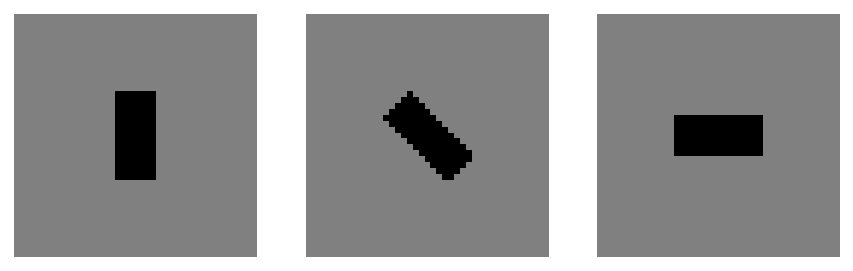

In [8]:
plt.figure(figsize=(10, 5))

for i, img in enumerate(bar_set1.images()):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

In [9]:
print(bar_set1.canvas_size)
print(bar_set1.locations)
print(bar_set1.lengths)
print(bar_set1.widths)
print(bar_set1.contrasts)
print(bar_set1.orientations)
print(bar_set1.grey_levels)
print(bar_set1.pixel_boundaries)

[41, 41]
[[20.2, 20.2]]
[15.0]
[7.0]
[-1]
[0.0, 0.7853981633974483, 1.5707963267948966]
[0.0]
[-1, 1]


In [10]:
# with lists -> bar_set2
locations    = [[20, 20], [20, 20]]
lengths      = [11.0]
widths       = [5.0]
contrasts    = [-1] 
orientations = [np.pi/4, np.pi/2] 
grey_levels  = [0.0]

# class object
bar_set2 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [11]:
print(bar_set2.canvas_size)
print(bar_set2.locations)
print(bar_set2.lengths)
print(bar_set2.widths)
print(bar_set2.contrasts)
print(bar_set2.orientations)
print(bar_set2.grey_levels)
print(bar_set2.pixel_boundaries)

[41, 41]
[[20, 20], [20, 20]]
[11.0]
[5.0]
[-1]
[0.7853981633974483, 1.5707963267948966]
[0.0]
[-1, 1]


In [12]:
# search methods should only be supported for objects of parameters.py
bar_set2.find_optimal_stimulus(model, data_key, unit_idx)

TypeError: find_optimal_stimulus search method only supports input parameters from module parameters.py

In [13]:
# FiniteSelection -> bar_set3
np.random.seed(None)
locations    = FiniteSelection([[20, 20], [20, 20]])
lengths      = FiniteSelection([5.0, 7.0], n=4, pmf=[0.05, 0.95])
widths       = FiniteSelection([2.0, 3.0])
contrasts    = FiniteSelection([-1, 1]) 
orientations = FiniteSelection([0.0, np.pi/4, np.pi/2]) 
grey_levels  = FiniteSelection([0.0, 0.5])

# class object
bar_set3 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [14]:
print(bar_set3.canvas_size)
print(bar_set3.locations)
print(bar_set3.lengths)
print(bar_set3.widths)
print(bar_set3.contrasts)
print(bar_set3.orientations)
print(bar_set3.grey_levels)
print(bar_set3.pixel_boundaries)

[41, 41]
[[20, 20]]
[7.0, 7.0, 7.0, 7.0]
[2.0]
[1]
[1.5707963267948966]
[0.0]
[-1, 1]


In [15]:
# UniformRange -> bar_set4
np.random.seed(None)
locations    = UniformRange([[10, 30], [10, 30]])
lengths      = UniformRange([10.0, 20.0])
widths       = UniformRange([4.0, 9.0])
contrasts    = UniformRange([-1.0, 1.0]) 
orientations = UniformRange([0.0, np.pi/2]) 
grey_levels  = FiniteParameter([0.0])

# class object
bar_set4 = BarsSet(canvas_size=canvas_size,
                   locations=locations,
                   lengths=lengths,
                   widths=widths,
                   contrasts=contrasts,
                   orientations=orientations,
                   grey_levels=grey_levels)

In [16]:
print("Samples:", bar_set4.canvas_size, bar_set4.locations, bar_set4.lengths, bar_set4.widths, bar_set4.contrasts, bar_set4.orientations, bar_set4.grey_levels, bar_set4.pixel_boundaries)
print("Ranges:", bar_set4.locations_range, bar_set4.lengths_range, bar_set4.widths_range, bar_set4.contrasts_range, bar_set4.orientations_range)

Samples: [41, 41] [[16.691971517029902, 14.422915612002909]] [16.726726181047443] [6.257934810952241] [0.5718469998373339] [1.2304174368063039] [0.0] [-1, 1]
Ranges: [[10, 30], [10, 30]] [10.0, 20.0] [4.0, 9.0] [-1.0, 1.0] [0.0, 1.5707963267948966]


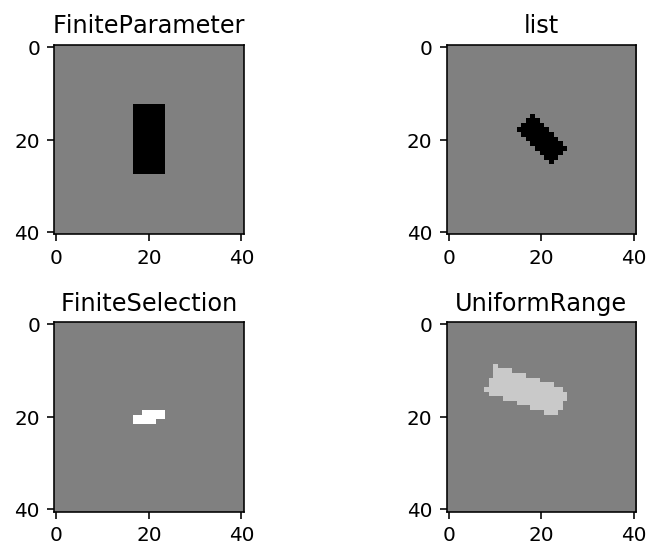

In [17]:
plt.subplot(221)
plt.imshow(bar_set1.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("FiniteParameter")

plt.subplot(222)
plt.imshow(bar_set2.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("list")

plt.subplot(223)
plt.imshow(bar_set3.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("FiniteSelection")

plt.subplot(224)
plt.imshow(bar_set4.stimulus_from_idx(0), cmap="gray", vmin=-1, vmax=1)
plt.title("UniformRange")

plt.tight_layout()

In [ ]:
best_bar4_params, best_bar4_values = bar_set4.find_optimal_stimulus(model=model, data_key=data_key, unit_idx=unit_idx)

In [19]:
bar4_stim_opt = bar_set4.get_image_from_params(best_bar4_params)

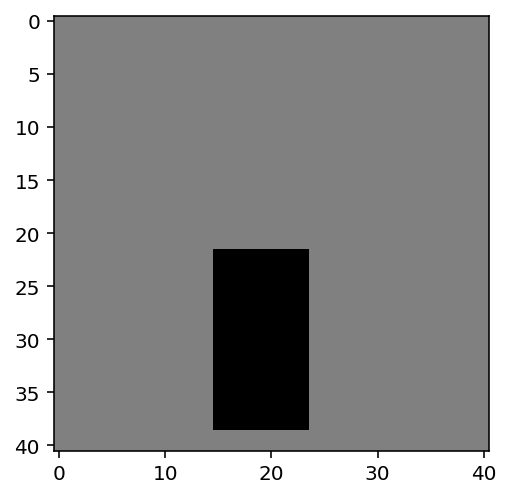

In [20]:
plt.imshow(bar4_stim_opt, cmap="gray", vmin=-1, vmax=1)

In [21]:
print(best_bar4_params)

{'location_width': 19, 'location_height': 30, 'length': 17.172103188309897, 'width': 8.74147633838519, 'contrast': -1.0, 'orientation': 0.0, 'grey_level': 0.0}


# Gabor class

In [22]:
# case 0: list class -> gabor_set0

# Choose the input parameters
canvas_size         = [w, h]
sizes               = [10.0, 20.0]
spatial_frequencies = [1/20, 1/5]
contrasts           = [0.5, 0.75, 1.0]
grey_levels         = [0.0]
eccentricities      = [0.0, 0.9]
locations           = [[25.0, 30.0]]
orientations        = [val * (np.pi) / 8 for val in range(0, 8)]  
phases              = [val * (2*np.pi) / 8 for val in range(0, 8)]

# Instantiate the Gabor class
gabor_set0 = GaborSet(canvas_size=canvas_size,
                      sizes=sizes,
                      spatial_frequencies=spatial_frequencies,
                      contrasts=contrasts,
                      orientations=orientations,
                      phases=phases, 
                      grey_levels=grey_levels,
                      eccentricities=eccentricities,
                      locations=locations,
                      relative_sf=False)

In [23]:
# the attribute 'auto_params' should not exist for stimulus sets initialized with at least one list 
gabor_set0.auto_params

AttributeError: 'GaborSet' object has no attribute 'auto_params'

In [24]:
# case 1: FiniteParameter class -> gabor_set1

# Choose the input parameters
canvas_size         = [w, h]
sizes               = FiniteParameter([10.0, 20.0])
spatial_frequencies = FiniteParameter([1/20, 1/5])
contrasts           = FiniteParameter([0.5, 0.75, 1.0])
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([0.0, 0.9])
locations           = FiniteParameter([[25.0, 30.0]])

orientation_values = [val * (np.pi) / 8 for val in range(0, 8)]  
orientations = FiniteParameter(orientation_values)

phase_values = [val * (2*np.pi) / 8 for val in range(0, 8)]
phases = FiniteParameter(phase_values)

In [25]:
# Instantiate the Gabor class
gabor_set1 = GaborSet(canvas_size=canvas_size,
                      sizes=sizes,
                      spatial_frequencies=spatial_frequencies,
                      contrasts=contrasts,
                      orientations=orientations,
                      phases=phases, 
                      grey_levels=grey_levels,
                      eccentricities=eccentricities,
                      locations=locations,
                      relative_sf=False)

In [26]:
gabor_set1.arg_dict

{'self': <insilico_stimuli.stimuli.GaborSet at 0x7fc8f037ee10>,
 'canvas_size': [41, 41],
 'locations': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f032c350>,
 'sizes': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f02914d0>,
 'spatial_frequencies': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f0291210>,
 'contrasts': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f032c110>,
 'orientations': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f032c190>,
 'phases': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f032c5d0>,
 'grey_levels': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f032cf90>,
 'eccentricities': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8f032c3d0>,
 'pixel_boundaries': None,
 'relative_sf': False}

In [27]:
gabor_set1.auto_params

{'location_width': {'name': 'location_width', 'type': 'fixed', 'value': 25.0},
 'location_height': {'name': 'location_height',
  'type': 'fixed',
  'value': 30.0},
 'size': {'name': 'size', 'type': 'choice', 'values': [10.0, 20.0]},
 'spatial_frequency': {'name': 'spatial_frequency',
  'type': 'choice',
  'values': [0.05, 0.2]},
 'contrast': {'name': 'contrast',
  'type': 'choice',
  'values': [0.5, 0.75, 1.0]},
 'orientation': {'name': 'orientation',
  'type': 'choice',
  'values': [0.0,
   0.39269908169872414,
   0.7853981633974483,
   1.1780972450961724,
   1.5707963267948966,
   1.9634954084936207,
   2.356194490192345,
   2.748893571891069]},
 'phase': {'name': 'phase',
  'type': 'choice',
  'values': [0.0,
   0.7853981633974483,
   1.5707963267948966,
   2.356194490192345,
   3.141592653589793,
   3.9269908169872414,
   4.71238898038469,
   5.497787143782138]},
 'gamma': {'name': 'gamma',
  'type': 'choice',
  'values': [1.0, 0.18999999999999995]},
 'grey_level': {'name': 'grey_l

In [ ]:
# Find the best among all defined gabor images (via Bayesian Search), for one specific model neuron
unit_idx = 27
best_gabor1_params_bayes, values_gabor1_bayes = gabor_set1.find_optimal_stimulus(model = model, 
                                                                                 data_key = data_key,
                                                                                 unit_idx = unit_idx,
                                                                                 total_trials = total_trials)

In [ ]:
# best gabor for all model neurons
best_gabor1_params_bayes = []
values_gabor1_bayes = []
for unit in range(0, n_units):
    best_params, values = gabor_set1.find_optimal_stimulus(model = model, 
                                                           data_key = data_key,
                                                           unit_idx = unit, 
                                                           total_trials = total_trials)
    best_gabor1_params_bayes.append(best_params)
    values_gabor1_bayes.append(values)

In [86]:
print(values_gabor1_bayes[0])

({'activation': 1.4887889623641968}, {'activation': {'activation': 0.0}})


Text(0.5, 1.0, 'Gabor from Bayes search with activation 1.49')

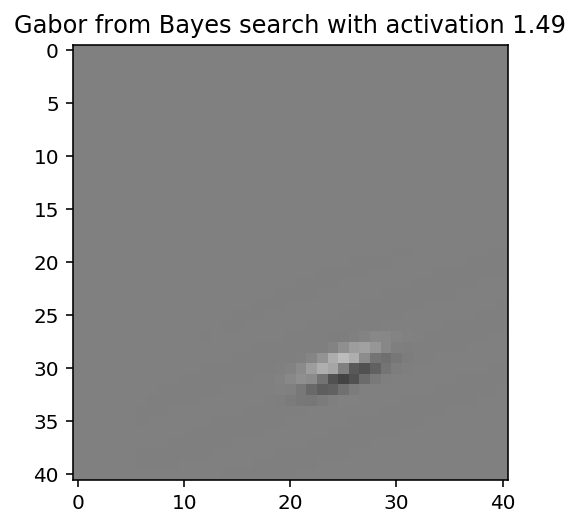

In [90]:
plt.imshow(gabor_set1.get_image_from_params(best_gabor1_params_bayes[0]), cmap="gray", vmin=-1, vmax=1)
plt.title('Gabor from Bayes search with activation {}'.format(round(values_gabor1_bayes[0][0]['activation'], 2)))

In [31]:
# Find the best among all defined gabor images (via BruteForce Search)
best_gabor1_params_bf, values_gabor1_bf = gabor_set1.find_optimal_stimulus_bruteforce(model = model, 
                                                                                      data_key = data_key, 
                                                                                      batch_size = 100, 
                                                                                      return_activations = False, 
                                                                                      unit_idx = None,
                                                                                      plotflag = False)

In [76]:
print(values_gabor1_bf.shape)

(1536, 29)


In [62]:
# get best_gabor1_params_bf in a format, where we can use the method get_image_from_params to generate the image
par0_bf = best_gabor1_params_bf[0].copy()
img_par0_bf = gabor_set1.stimulus(**par0_bf)

Text(0.5, 1.0, 'Gabor from BF search with activation 5.1')

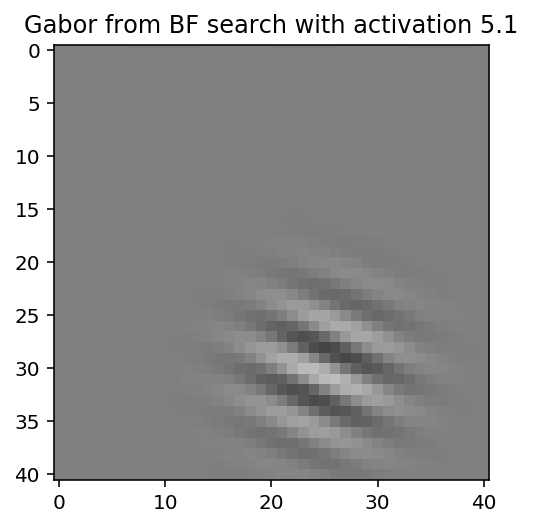

In [80]:
plt.imshow(img_par0_bf, cmap="gray", vmin=-1, vmax=1)
plt.title('Gabor from BF search with activation {}'.format(np.round(np.max(values_gabor1_bf[0]), 2)))

In [64]:
# try different types of input arguments (hybrid example with some "finite" and some "infinite" parameter sets)
canvas_size         = [w, h]
sizes               = UniformRange([10.0, 40.0])
spatial_frequencies = UniformRange([1/40, 1/5])
contrasts           = FiniteParameter([0.5, 0.75, 1.0])
orientations        = UniformRange([0.0, np.pi])
phases              = UniformRange([0.0, 2*np.pi])
grey_levels         = FiniteParameter([0.0])
eccentricities      = UniformRange([0.0, 0.9])

# search on every pixel except the ones too far at the image corners
locs = [[float(w), float(h)] for w in range(0 + 8, 41 - 8)
               for h in range(0 + 8, 41 - 8)]
locations = FiniteParameter(locs)

In [ ]:
# do Bayesian Search again with new parameter set

gabor_set2 = GaborSet(canvas_size=canvas_size,
                      sizes=sizes,
                      spatial_frequencies=spatial_frequencies,
                      contrasts=contrasts,
                      orientations=orientations,
                      phases=phases, 
                      grey_levels=grey_levels,
                      eccentricities=eccentricities,
                      locations=locations,
                      relative_sf=False)

# for all model neurons
best_gabor2_params_list = []
values_gabor2_list = []
for unit in range(0, n_units):
    best_params, values = gabor_set2.find_optimal_stimulus(model = model, 
                                                           data_key = data_key,
                                                           unit_idx = unit, 
                                                           total_trials = total_trials)
    best_gabor2_params_list.append(best_params)
    values_gabor2_list.append(values)

Text(0.5, 1.0, 'Gabor from Bayes search with activation 1.48')

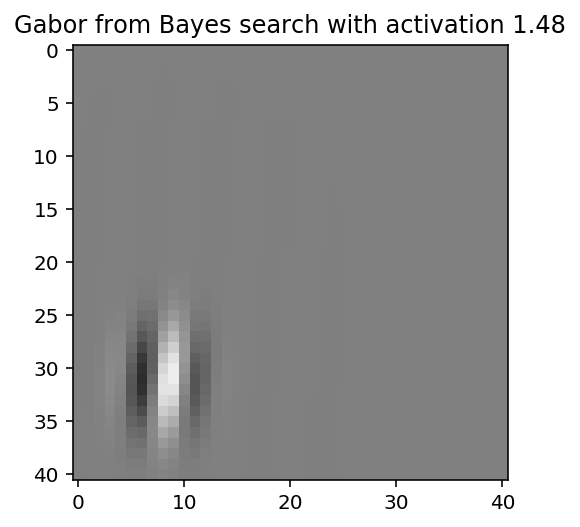

In [89]:
gabor2_stim = gabor_set2.get_image_from_params(best_gabor2_params_list[0])
plt.imshow(gabor2_stim, cmap="gray", vmin=-1, vmax=1)
plt.title('Gabor from Bayes search with activation {}'.format(round(values_gabor2_list[0][0]['activation'], 2)))

In [35]:
gabor_set1.contrasts

[0.5, 0.75, 1.0]

# Plaids class

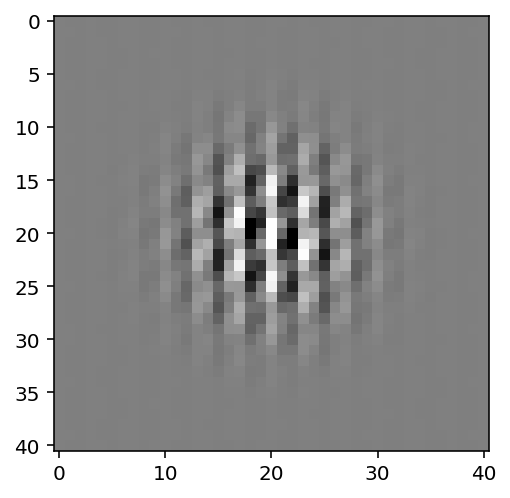

In [36]:
# choose parameter configuration
# Choose the input parameters
canvas_size         = [w, h]
locations           = FiniteParameter([[20.0, 20.0]])
sizes               = FiniteParameter([20.0])
spatial_frequencies = FiniteParameter([3/10, 4/10, 5/10])
orientations        = FiniteParameter(list(np.arange(0, np.pi, np.pi/8)))
phases              = FiniteParameter([0.0])
contrasts_preferred = FiniteParameter([0.5, 0.75, 1.0])
contrasts_overlap   = FiniteParameter([0.5, 0.75, 1.0])
grey_levels         = FiniteParameter([0.0])
angles              = FiniteParameter(list(np.arange(0, np.pi, np.pi/8)))

# instantiate plaids class
plaids_set1 = PlaidsGaborSet(canvas_size=canvas_size, 
                             locations=locations,
                             sizes=sizes,
                             spatial_frequencies=spatial_frequencies,
                             orientations=orientations,
                             phases=phases,
                             contrasts_preferred=contrasts_preferred,
                             contrasts_overlap=contrasts_overlap, 
                             grey_levels=grey_levels, 
                             angles=angles)

# plot one of the generated images
plt.imshow(plaids_set1.stimulus_from_idx(54), cmap='gray', vmin=-1, vmax=1)

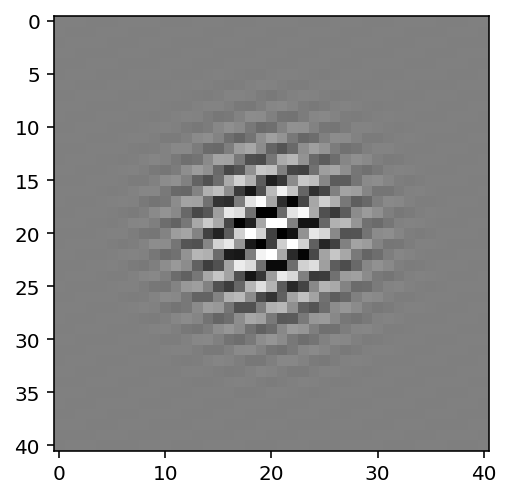

In [37]:
# random plaid (sampled from finite selection, without pmf)
canvas_size         = [w, h]
locations           = FiniteSelection([[20,20]])
sizes               = FiniteSelection([20])
spatial_frequencies = FiniteSelection([3/10, 4/10, 5/10])
orientations        = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))
phases              = FiniteSelection(list(np.arange(0, 2*np.pi, np.pi/8)))
contrasts_preferred = FiniteSelection([0.5, 0.75, 1.0])
contrasts_overlap   = FiniteSelection([0.5, 0.75, 1.0])
grey_levels         = FiniteSelection([0.0])
angles              = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))

# instantiate plaids class
plaids_set2 = PlaidsGaborSet(canvas_size = [41, 41], 
                             locations=locations,
                             sizes=sizes,
                             spatial_frequencies=spatial_frequencies,
                             orientations=orientations,
                             phases=phases,
                             contrasts_preferred=contrasts_preferred,
                             contrasts_overlap=contrasts_overlap, 
                             grey_levels=grey_levels, 
                             angles=angles)

# plot the generated image
plt.imshow(plaids_set2.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)

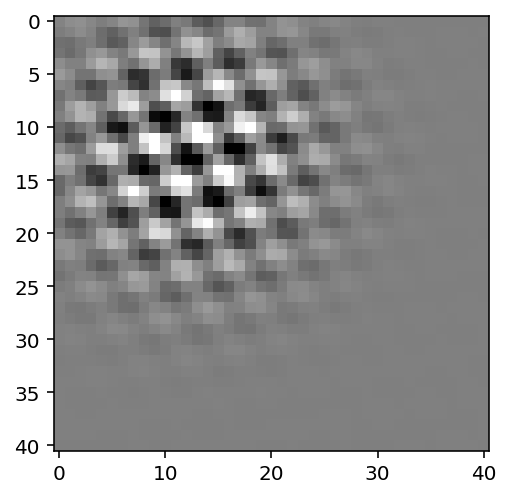

In [38]:
# random plaid (sampled from parameter range, without pseudo_inverse density)
canvas_size         = [w, h]
locations           = UniformRange([[8, 34], [8, 34]])
sizes               = UniformRange([10, 40])
spatial_frequencies = UniformRange([1/80, 4/10])
orientations        = UniformRange([0, np.pi])
phases              = UniformRange([0, 2*np.pi])
contrasts_preferred = UniformRange([0.5, 1.0])
contrasts_overlap   = UniformRange([0.5, 1.0])
grey_levels         = FiniteParameter([0.0])
angles              = UniformRange([0, np.pi])

# instantiate plaids class
plaids_set3 = PlaidsGaborSet(canvas_size = [41, 41], 
                             locations=locations,
                             sizes=sizes,
                             spatial_frequencies=spatial_frequencies,
                             orientations=orientations,
                             phases=phases,
                             contrasts_preferred=contrasts_preferred,
                             contrasts_overlap=contrasts_overlap, 
                             grey_levels=grey_levels, 
                             angles=angles)

# plot the generated image
plt.imshow(plaids_set3.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)

# DiffOfGaussian class

In [39]:
# UniformRange: DoG1
canvas_size              = [w, h]
locations                = UniformRange([[15.0, 35.0], [15.0, 35.0]])
sizes                    = UniformRange([10.0, 35.0])
sizes_scale_surround     = UniformRange([1.01, 2.0])
contrasts                = UniformRange([-1.0, 1.0])
contrasts_scale_surround = UniformRange([0.0, 1.0])
grey_levels              = FiniteParameter([0.0])

DoG1 = DiffOfGaussians(canvas_size=canvas_size, 
                       locations=locations,
                       sizes=sizes,
                       sizes_scale_surround=sizes_scale_surround,
                       contrasts=contrasts,
                       contrasts_scale_surround=contrasts_scale_surround, 
                       grey_levels=grey_levels)
                       #pixel_boundaries=None)

In [40]:
DoG1.arg_dict

{'self': <insilico_stimuli.stimuli.DiffOfGaussians at 0x7fc8ebe72450>,
 'canvas_size': [41, 41],
 'locations': <insilico_stimuli.parameters.UniformRange at 0x7fc8ebe54890>,
 'sizes': <insilico_stimuli.parameters.UniformRange at 0x7fc8ebe54910>,
 'sizes_scale_surround': <insilico_stimuli.parameters.UniformRange at 0x7fc8ebe54310>,
 'contrasts': <insilico_stimuli.parameters.UniformRange at 0x7fc8ebe54f90>,
 'contrasts_scale_surround': <insilico_stimuli.parameters.UniformRange at 0x7fc8ebe545d0>,
 'grey_levels': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8ebe54090>,
 'pixel_boundaries': None}

In [ ]:
# find optimal DoG stimulus for the given infinite parameter set
unit_idx=25
best_DoG1_params, values_DoG1 = DoG1.find_optimal_stimulus(model = model, 
                                                           data_key = data_key,
                                                           unit_idx = unit_idx,
                                                           total_trials=30)

In [42]:
print(best_DoG1_params)

{'location_width': 29.03093222272758, 'location_height': 25.296296870520692, 'size': 24.358664949918435, 'size_scale_surround': 1.665670453595414, 'contrast': -0.9999999999999997, 'contrast_scale_surround': 0.7754721100399121, 'grey_level': 0.0}


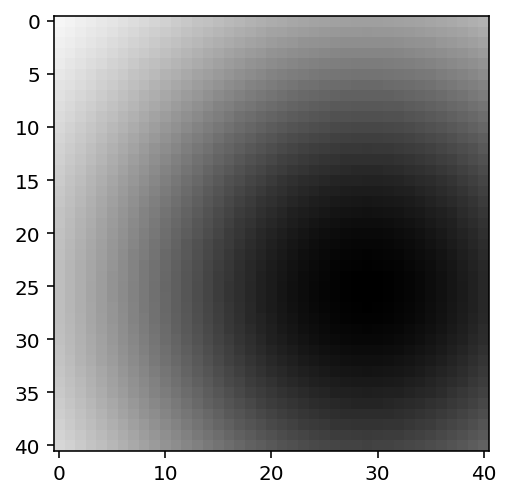

In [43]:
plt.imshow(DoG1.get_image_from_params(best_DoG1_params), cmap="gray", vmin=-1, vmax=1)

# Center Surround class

In [44]:
# Hybrid Parameter types
canvas_size                = [w, h]
locations                  = FiniteParameter([[20.0, 20.0]])  # fixed position
sizes_total                = UniformRange([5.0, 13.0])        # variable size within range [5.0, 13.0]
sizes_center               = FiniteParameter([1.0])           # only center
sizes_surround             = FiniteParameter([1.1])           # only center
contrasts_center           = FiniteSelection([0.75, 1.0])     # try 2 contrasts
contrasts_surround         = FiniteParameter([0.75])          # only center
orientations_center        = UniformRange([0.0, np.pi])       # variable orientation
orientations_surround      = UniformRange([0.0, np.pi])       # center only
spatial_frequencies_center = FiniteParameter([0.2])           # fixed spatial frequency
phases_center              = UniformRange([0.0, 2*np.pi])     # variable center phase 
grey_levels                = FiniteParameter([0.0])           # fixed grey level

# call center-surround
cs1 = CenterSurround(canvas_size=canvas_size, 
                     locations=locations,
                     sizes_total=sizes_total,
                     sizes_center=sizes_center,
                     sizes_surround=sizes_surround,
                     contrasts_center=contrasts_center,
                     contrasts_surround=contrasts_surround,
                     orientations_center=orientations_center,
                     orientations_surround=orientations_surround,
                     spatial_frequencies_center=spatial_frequencies_center,
                     phases_center=phases_center,
                     grey_levels=grey_levels)
               

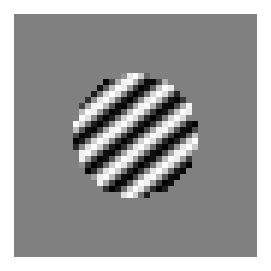

In [45]:
plt.figure(figsize=(10, 5))

for i, img in enumerate(cs1.images()):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

In [46]:
cs1.arg_dict

{'self': <insilico_stimuli.stimuli.CenterSurround at 0x7fc92415fd90>,
 'canvas_size': [41, 41],
 'locations': <insilico_stimuli.parameters.FiniteParameter at 0x7fc924148f50>,
 'sizes_total': <insilico_stimuli.parameters.UniformRange at 0x7fc924148ad0>,
 'sizes_center': <insilico_stimuli.parameters.FiniteParameter at 0x7fc924148e90>,
 'sizes_surround': <insilico_stimuli.parameters.FiniteParameter at 0x7fc924148a10>,
 'contrasts_center': <insilico_stimuli.parameters.FiniteSelection at 0x7fc924148b90>,
 'contrasts_surround': <insilico_stimuli.parameters.FiniteParameter at 0x7fc9241483d0>,
 'orientations_center': <insilico_stimuli.parameters.UniformRange at 0x7fc924148410>,
 'orientations_surround': <insilico_stimuli.parameters.UniformRange at 0x7fc9241488d0>,
 'spatial_frequencies_center': <insilico_stimuli.parameters.FiniteParameter at 0x7fc92415fcd0>,
 'phases_center': <insilico_stimuli.parameters.UniformRange at 0x7fc92415f810>,
 'grey_levels': <insilico_stimuli.parameters.FiniteParame

In [ ]:
cs1_best_params, cs1_values = cs1.find_optimal_stimulus(model, data_key, unit_idx)

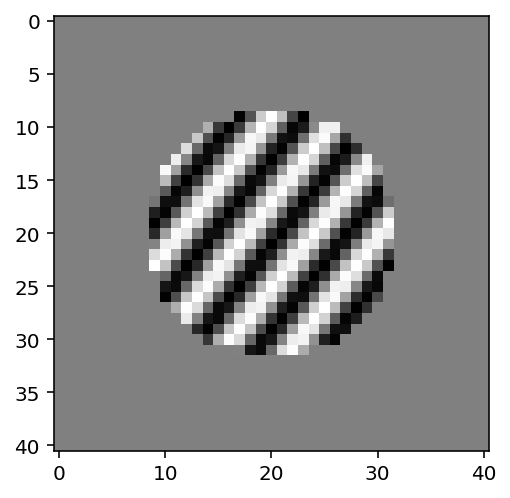

In [48]:
# plot the image that activates the given unit the most from the given parameter set
plt.imshow(cs1.get_image_from_params(cs1_best_params), cmap="gray", vmin=-1, vmax=1)

In [49]:
# managing to have a gap in between the center and surround 
canvas_size                = [w, h]
locations                  = [[20.0, 20.0]]
sizes_total                = [13.0]
sizes_center               = FiniteParameter([0.7])
sizes_surround             = [0.7]
contrasts_center           = [0.0, 1.0]
contrasts_surround         = [1.0]
orientations_center        = [val * (np.pi) / 4 for val in range(0, 4)]
orientations_surround      = [np.pi]
spatial_frequencies_center = [0.2]
phases_center              = UniformRange([0.0, 2*np.pi], n=2)
grey_levels                = [0.0]

# call center-surround
cs2 = CenterSurround(canvas_size=canvas_size, 
                     locations=locations,
                     sizes_total=sizes_total,
                     sizes_center=sizes_center,
                     sizes_surround=sizes_surround,
                     contrasts_center=contrasts_center,
                     contrasts_surround=contrasts_surround,
                     orientations_center=orientations_center,
                     orientations_surround=orientations_surround,
                     spatial_frequencies_center=spatial_frequencies_center,
                     phases_center=phases_center,
                     grey_levels=grey_levels)
               

In [50]:
cs2.arg_dict

{'self': <insilico_stimuli.stimuli.CenterSurround at 0x7fc8ebf594d0>,
 'canvas_size': [41, 41],
 'locations': [[20.0, 20.0]],
 'sizes_total': [13.0],
 'sizes_center': <insilico_stimuli.parameters.FiniteParameter at 0x7fc8ebf59f50>,
 'sizes_surround': [0.7],
 'contrasts_center': [0.0, 1.0],
 'contrasts_surround': [1.0],
 'orientations_center': [0.0,
  0.7853981633974483,
  1.5707963267948966,
  2.356194490192345],
 'orientations_surround': [3.141592653589793],
 'spatial_frequencies_center': [0.2],
 'phases_center': <insilico_stimuli.parameters.UniformRange at 0x7fc8ebf59950>,
 'grey_levels': [0.0],
 'spatial_frequencies_surround': None,
 'phases_surround': None,
 'pixel_boundaries': None}

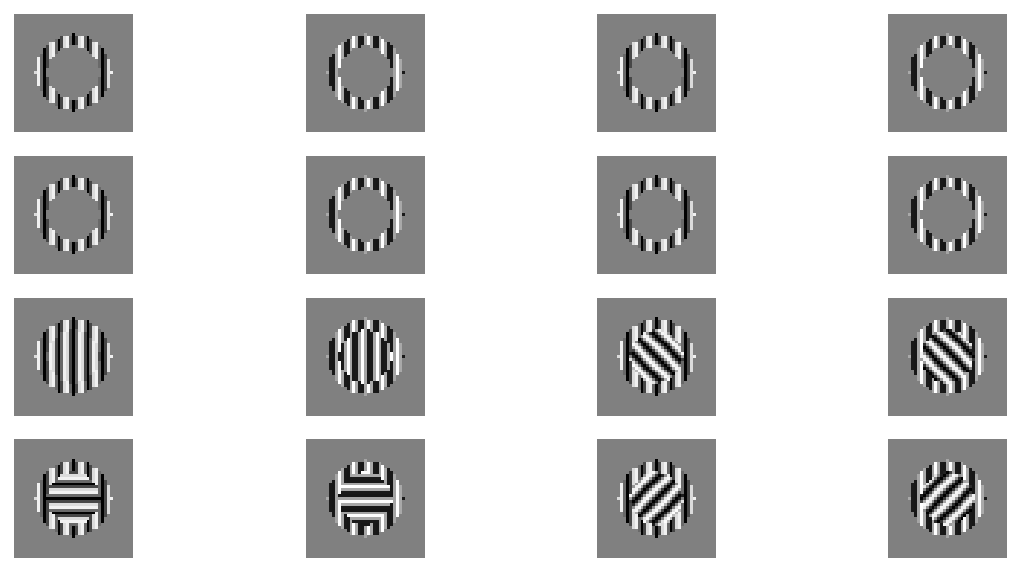

In [51]:
plt.figure(figsize=(10, 5))

for i, img in enumerate(cs2.images()):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

# PlaidsGrating class

In [52]:
# FiniteParameter: plaid_grating1
canvas_size          = [w, h]
locations            = FiniteParameter([[20.0, 20.0]])
sizes_total          = FiniteParameter([10.0])
#spatial_frequencies  = FiniteParameter([0.3])
spatial_frequencies  = FiniteParameter([0.1])
orientations         = FiniteParameter([0.0])
phases               = FiniteParameter([0.0])
contrasts_preferred  = FiniteParameter([0.5, 0.75, 1.0])
contrasts_overlap    = FiniteParameter([0.5, 0.75, 1.0])
grey_levels          = FiniteParameter([0.0])
angles               = FiniteParameter(list(np.arange(0, np.pi, np.pi/8)))
#angles               = FiniteParameter([np.pi/2])

plaid_grating1 = PlaidsGratingSet(canvas_size=canvas_size, 
                                  sizes_total=sizes_total,
                                  locations=locations,
                                  contrasts_preferred=contrasts_preferred,
                                  contrasts_overlap=contrasts_overlap, 
                                  spatial_frequencies=spatial_frequencies,
                                  orientations=orientations,
                                  phases=phases,
                                  grey_levels=grey_levels, 
                                  angles=angles,
                                  #angles = None,
                                  pixel_boundaries=None)

In [53]:
# FiniteSelection: plaid_grating2
canvas_size         = [w, h]
locations           = FiniteSelection([[20,20]])
sizes               = FiniteSelection([20])
spatial_frequencies = FiniteSelection([3/10, 4/10, 5/10])
orientations        = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))
phases              = FiniteSelection(list(np.arange(0, 2*np.pi, np.pi/8)))
contrasts_preferred = FiniteSelection([0.5, 0.75, 1.0])
contrasts_overlap   = FiniteSelection([0.5, 0.75, 1.0])
grey_levels         = FiniteSelection([0.0])
angles              = FiniteSelection(list(np.arange(0, np.pi, np.pi/8)))

plaid_grating2 = PlaidsGratingSet(canvas_size=canvas_size, 
                                  sizes_total=sizes_total,
                                  locations=locations,
                                  contrasts_preferred=contrasts_preferred,
                                  contrasts_overlap=contrasts_overlap, 
                                  spatial_frequencies=spatial_frequencies,
                                  orientations=orientations,
                                  phases=phases,
                                  grey_levels=grey_levels, 
                                  angles=angles,
                                  pixel_boundaries=None)

In [54]:
# UniformRange: plaid_grating3
canvas_size         = [w, h]
locations           = UniformRange([[8, 34], [8, 34]])
sizes               = UniformRange([10, 40])
spatial_frequencies = UniformRange([1/80, 4/10])
orientations        = UniformRange([0, np.pi])
phases              = UniformRange([0, 2*np.pi])
contrasts_preferred = UniformRange([0.5, 1.0])
contrasts_overlap   = UniformRange([0.5, 1.0])
grey_levels         = FiniteParameter([0.0])
angles              = UniformRange([0, np.pi])

plaid_grating3 = PlaidsGratingSet(canvas_size=canvas_size, 
                                  sizes_total=sizes_total,
                                  locations=locations,
                                  contrasts_preferred=contrasts_preferred,
                                  contrasts_overlap=contrasts_overlap, 
                                  spatial_frequencies=spatial_frequencies,
                                  orientations=orientations,
                                  phases=phases,
                                  grey_levels=grey_levels, 
                                  angles=angles,
                                  pixel_boundaries=None)

In [55]:
print(plaid_grating1.params_dict_from_idx(0))

{'location': [20.0, 20.0], 'size_total': 10.0, 'contrast_preferred': 0.5, 'contrast_overlap': 0.5, 'spatial_frequency': 0.1, 'orientation': 0.0, 'phase': 0.0, 'angle': 0.0, 'grey_level': 0.0}


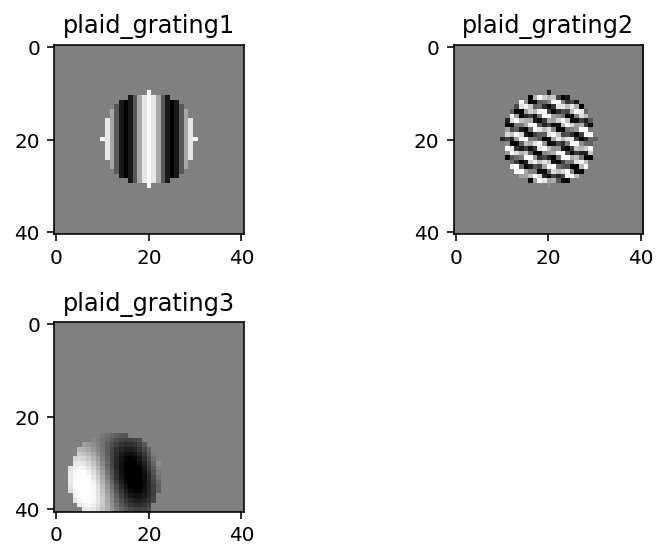

In [56]:
plt.subplot(221)
plt.imshow(plaid_grating1.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)
plt.title("plaid_grating1")

plt.subplot(222)
plt.imshow(plaid_grating2.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)
plt.title("plaid_grating2")

plt.subplot(223)
plt.imshow(plaid_grating3.stimulus_from_idx(0), cmap='gray', vmin=-1, vmax=1)
plt.title("plaid_grating3")

plt.tight_layout()